ここからの改変

https://github.com/t-sakai-kure/pywsl/blob/master/examples/pul/upu/demo_upu.py

In [1]:
import numpy as np

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.estimator_checks import check_estimator

from pywsl.pul import pu_mr
from pywsl.utils.syndata import gen_twonorm_pu
from pywsl.utils.comcalc import bin_clf_err

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

# import seaborn as sns
# sns.set()

In [2]:
prior = .5
x, y, x_t, y_t = gen_twonorm_pu(n_p=30, n_u=200, 
                            prior_u=prior, n_t=100)

In [3]:
np.unique(y) #0がunlabelっぽい

array([0., 1.])

In [4]:
np.unique(y_t) #-1が負例である

array([-1.,  1.])

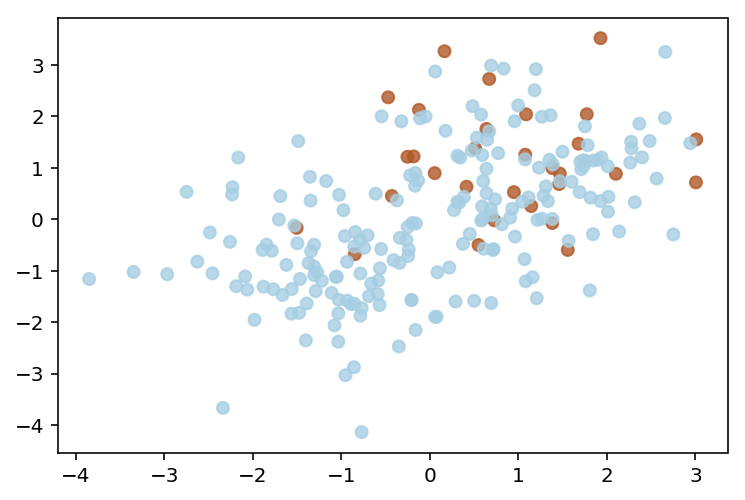

In [5]:
plt.scatter(x[:,0],x[:,1],c=y, alpha=0.8, cmap='Paired')
# plt.scatter(x_t[:,0],x_t[:,1]) #こっちはテストデーt

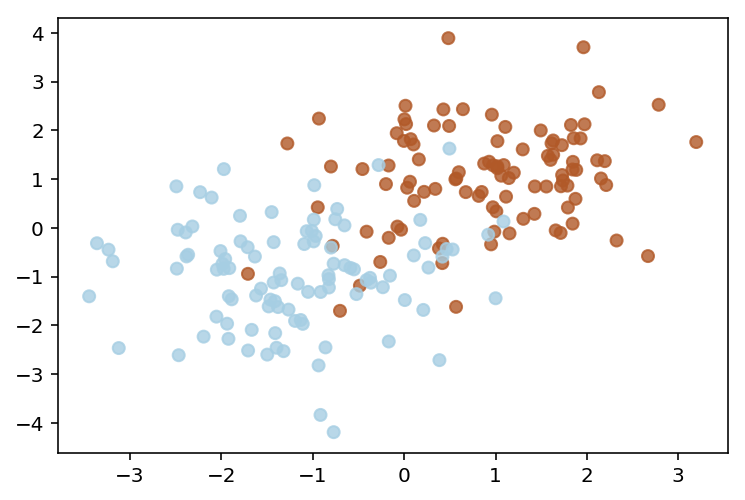

In [6]:
plt.scatter(x_t[:,0],x_t[:,1],c=y_t, alpha=0.8, cmap='Paired') #こっちはテストデーt
# こっちはちゃんと正例負例がついている

In [40]:
lambda_list = np.logspace(-3, 1, 5)
param_grid = {'prior': [0.5], #priorが多分、正負の割合 #推定方法あるがここでは決め打ち
          'lam': np.logspace(-10, 2, 100), 
#           'lam': np.logspace(-3, 1, 5), 
#           'sigma': np.logspace(0.1, 0.5, 10 ), #'lm'だったら探索する意味ないよね？
#           'basis': ['gauss']}
          'basis': ['lm']}
clf = GridSearchCV(estimator=pu_mr.PU_SL(), 
               param_grid=param_grid,
               cv=5, n_jobs=-1) #デフォだとaccで一番いいモデルを選択しているが、本来
clf.fit(x, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=PU_SL(basis='gauss', lam=1, n_basis=200, prior=0.5, sigma=0.1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'prior': [0.5], 'lam': array([1.00000e-10, 1.32194e-10, ..., 7.56463e+01, 1.00000e+02]), 'basis': ['lm']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
y_h = clf.predict(x_t)
err = 100*bin_clf_err(y_h, y_t, clf.best_estimator_.prior) #クラスの重みを考慮したaccの指標
print("MR: {:.2f}%".format(err))


MR: 10.50%


In [42]:
clf.best_estimator_.prior

0.5

In [43]:
??bin_clf_err

Signature: bin_clf_err(y_h, y_t, prior=None)
Docstring: <no docstring>
Source:   
def bin_clf_err(y_h, y_t, prior=None):
    # check y_t
    if prior:
        f_p = np.mean(y_h[y_t == +1] <= 0)
        f_n = np.mean(y_h[y_t == -1] >= 0)
        err = prior*f_p + (1-prior)*f_n
    else:
        err = np.mean(y_h*y_t <= 0)

    return err
File:      ~/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/pywsl/utils/comcalc.py
Type:      function


In [44]:
clf.best_estimator_
# PU_SLでどんな損失を使っているのかイマイチわからないんだけど？(二乗？ヒンジ？ランプ？)

PU_SL(basis='lm', lam=1.5199110829529332, n_basis=200, prior=0.5, sigma=0.1)

In [45]:
#より良く知るいはPU_SLの実装を追わなければならない

In [46]:
best_slf=clf.best_estimator_

In [47]:
xx,yy=np.meshgrid(np.arange(-4,4,0.1),
                 np.arange(-4,4,0.1))

In [48]:
xx

array([[-4. , -3.9, -3.8, ...,  3.7,  3.8,  3.9],
       [-4. , -3.9, -3.8, ...,  3.7,  3.8,  3.9],
       [-4. , -3.9, -3.8, ...,  3.7,  3.8,  3.9],
       ...,
       [-4. , -3.9, -3.8, ...,  3.7,  3.8,  3.9],
       [-4. , -3.9, -3.8, ...,  3.7,  3.8,  3.9],
       [-4. , -3.9, -3.8, ...,  3.7,  3.8,  3.9]])

In [49]:
yy

array([[-4. , -4. , -4. , ..., -4. , -4. , -4. ],
       [-3.9, -3.9, -3.9, ..., -3.9, -3.9, -3.9],
       [-3.8, -3.8, -3.8, ..., -3.8, -3.8, -3.8],
       ...,
       [ 3.7,  3.7,  3.7, ...,  3.7,  3.7,  3.7],
       [ 3.8,  3.8,  3.8, ...,  3.8,  3.8,  3.8],
       [ 3.9,  3.9,  3.9, ...,  3.9,  3.9,  3.9]])

In [50]:
xx.ravel()
yy.ravel()

array([-4. , -4. , -4. , ...,  3.9,  3.9,  3.9])

In [51]:
np.c_[xx.ravel()
,yy.ravel()]

#vstackしてreshapeと同じ

array([[-4. , -4. ],
       [-3.9, -4. ],
       [-3.8, -4. ],
       ...,
       [ 3.7,  3.9],
       [ 3.8,  3.9],
       [ 3.9,  3.9]])

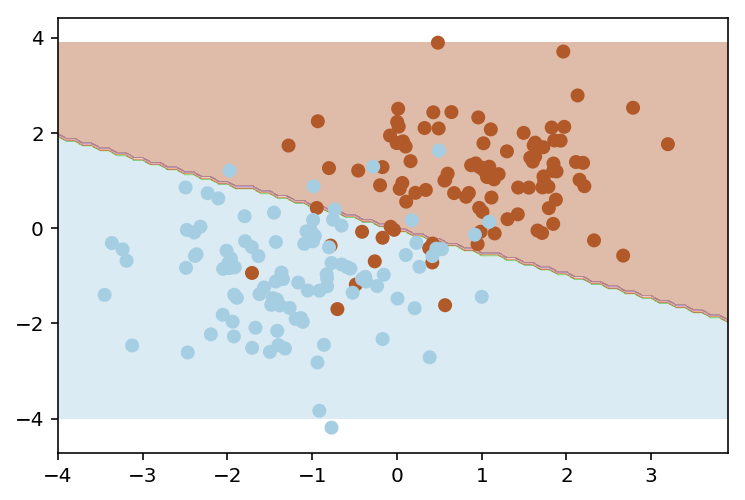

In [52]:
pred=best_slf.predict(np.c_[xx.ravel(),yy.ravel()])
plt.contourf(xx,yy, pred.reshape(xx.shape),alpha=0.4, cmap='Paired')
plt.scatter(x_t[:,0],x_t[:,1],c=y_t, cmap='Paired') #こっちはテスト

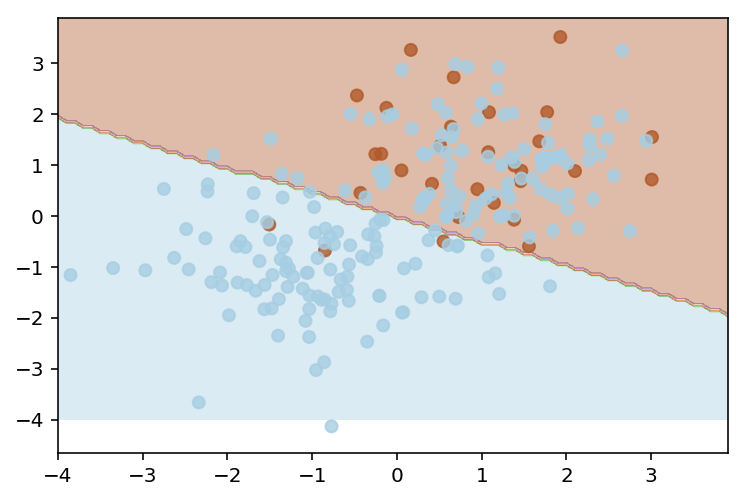

In [53]:
pred=best_slf.predict(np.c_[xx.ravel(),yy.ravel()])
plt.contourf(xx,yy, pred.reshape(xx.shape),alpha=0.4,cmap='Paired')
plt.scatter(x[:,0],x[:,1],c=y,alpha=0.8,cmap='Paired') 

In [54]:
best_slf.prior

0.5

In [36]:
def homo_coord(x):
    return np.c_[x, np.ones(x.shape[0])]

In [37]:
k=homo_coord(np.array([1,2,3,4,5]))

In [38]:
k.T.dot(k)

array([[55., 15.],
       [15.,  5.]])

In [39]:
np.random.binomial(10,0.9)

9